In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
from surprise import Reader, Dataset
from surprise import SVD
from surprise.model_selection import GridSearchCV
from surprise import Reader, Dataset, KNNBasic, SVD
from surprise.model_selection import GridSearchCV, cross_validate
sns.set()
sns.set_style("whitegrid")

# Load and inspect data

In [2]:
#Storing the user information into a pandas dataframe
movies_df = pd.read_csv('test/rec/20200522-Computerne.csv')
ratings_df = pd.read_csv('test/rec/20200522-Computerne_ratings.csv')


In [3]:
movies_df=movies_df.drop("title", 1)

In [4]:
movies_df.head()

,sceneId,start frame,end frame,duration in s,scene type
0,1,0,350,350.08,NaN
1,2,350,950,600.12,Whiteboard
2,3,950,1830,880.32,Professor
3,4,1830,2863,1032.96,NaN
4,5,2863,3178,314.52,Slides


## Descriptive statistic

In [5]:
ratings_df.describe(include='all')

,userId,sceneId,learningDuration in %,numberOfPosts
count,12000.000000,12000.000000,12000.000000,12000.000000
mean,500.500000,6.500000,45.701167,1.406750
std,288.687019,3.452196,28.301910,0.929001
min,1.000000,1.000000,0.000000,0.000000
25%,250.750000,3.750000,21.000000,1.000000
50%,500.500000,6.500000,48.000000,1.000000
75%,750.250000,9.250000,69.000000,2.000000
max,1000.000000,12.000000,100.000000,5.000000


## Check for duplicate

In [6]:
ratings_df[ratings_df.duplicated()] 

,userId,sceneId,learningDuration in %,numberOfPosts


## Check for null values 

In [7]:
ratings_df.isnull().sum()

userId                   0
sceneId                  0
learningDuration in %    0
numberOfPosts            0
dtype: int64

## Inspect features

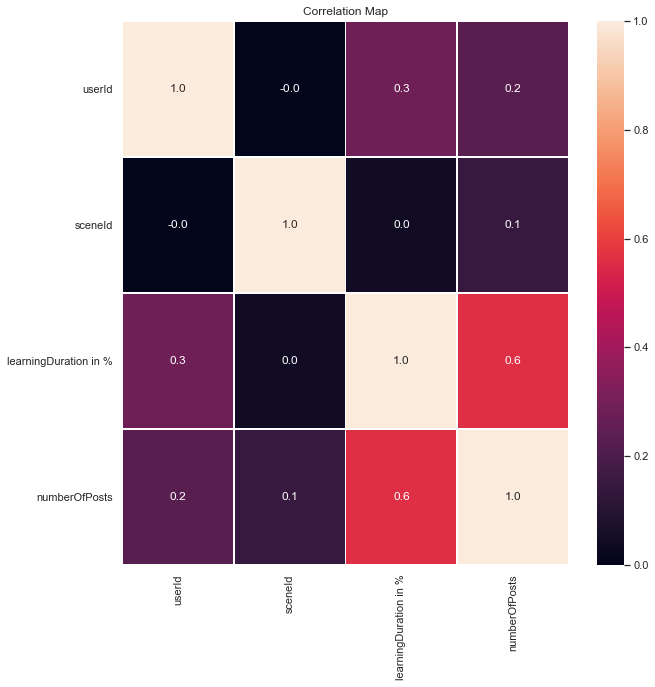

In [8]:
f,ax=plt.subplots(figsize = (10,10))
sns.heatmap(ratings_df.corr(),annot= True,linewidths=0.5,fmt = ".1f",ax=ax)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Correlation Map')
plt.show()

C:\Users\Lenovo330\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


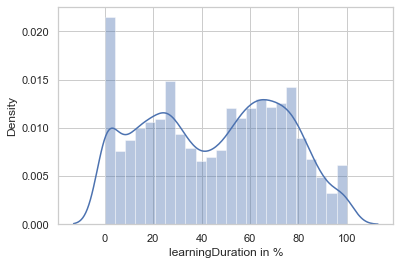

In [9]:
viz = sns.distplot(ratings_df['learningDuration in %'])
plt.show()

C:\Users\Lenovo330\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='numberOfPosts', ylabel='Density'>

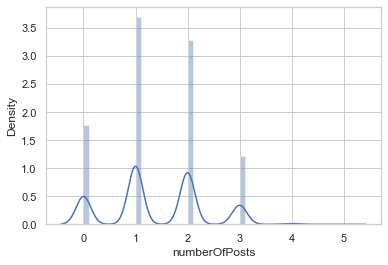

In [10]:
sns.distplot(ratings_df['numberOfPosts'])

## Compute explicite rating

In [11]:
def convertToExplicitRating():
    number_post_weight=2
    learning_duration_weight=5
    
    learning_duration_vector=ratings_df['learningDuration in %']
    #learning_duration_vector=learning_duration_vector*learning_duration_weight
    learning_duration_vector=(learning_duration_vector/100)*learning_duration_weight
      
    number_post_vector = ratings_df['numberOfPosts']
    number_post_vector = (np.log(1+number_post_vector)/math.log(1+max(number_post_vector)))*number_post_weight
       
    #rating_vector = learning_duration_vector
    rating_vector = learning_duration_vector
    ratings_df['rating']=rating_vector
    return ratings_df
    

In [12]:
explicit_data= convertToExplicitRating()

In [13]:
#Drop unnecessary features

explicit_data = explicit_data.drop('numberOfPosts', 1)
explicit_data = explicit_data.drop('learningDuration in %', 1)

In [14]:
explicit_data.head()

,userId,sceneId,rating
0,1,1,1.00
1,1,2,1.40
2,1,3,3.35
3,1,4,3.65
4,1,5,3.95


### Scene with best rating 

In [15]:
explicit_data.groupby('sceneId')['rating'].mean().sort_values(ascending=False).head()

sceneId
5     2.77215
4     2.70350
8     2.69625
3     2.62290
12    2.45905
Name: rating, dtype: float64

### Scene with higher rating

In [16]:
explicit_data.groupby('sceneId')['rating'].count().sort_values(ascending=False).head()

sceneId
1    1000
2    1000
3    1000
4    1000
5    1000
Name: rating, dtype: int64

In [17]:
explicit_data.replace([np.inf, -np.inf], np.nan, inplace=True)
explicit_data=explicit_data.fillna(0)
explicit_data=explicit_data.astype({"rating": np.int32})


### Distribution of ratings in data

<ipython-input-18-8307f7e76cd0>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([num for num in ax.get_yticks()])


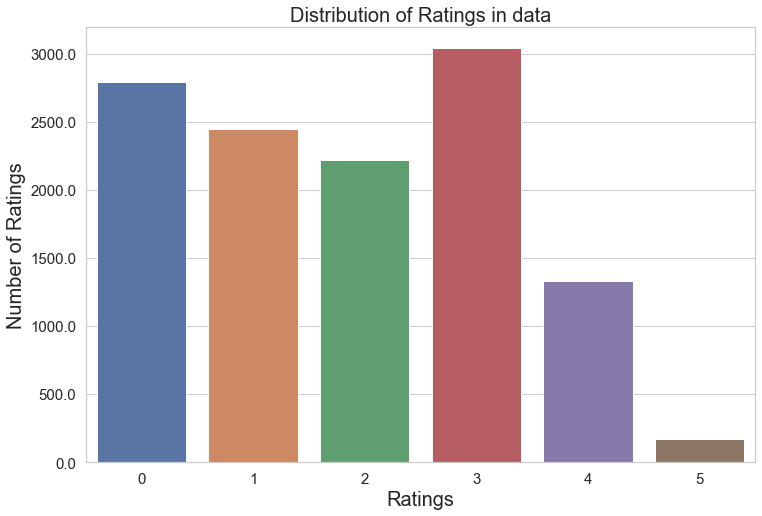

In [18]:
plt.figure(figsize = (12, 8))
ax = sns.countplot(x="rating", data=explicit_data)

ax.set_yticklabels([num for num in ax.get_yticks()])

plt.tick_params(labelsize = 15)
plt.title("Distribution of Ratings in data", fontsize = 20)
plt.xlabel("Ratings", fontsize = 20)
plt.ylabel("Number of Ratings", fontsize = 20)
plt.show()

C:\Users\Lenovo330\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='rating', ylabel='Density'>

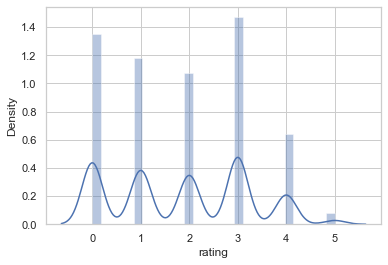

In [19]:
sns.distplot(explicit_data['rating'])

In [20]:

explicit_data.to_csv('data_preprocessed.csv')

In [21]:
explicit_data.head()

,userId,sceneId,rating
0,1,1,1
1,1,2,1
2,1,3,3
3,1,4,3
4,1,5,3


In [22]:
movie_matrix = explicit_data.pivot(index='userId', columns='sceneId',values='rating').fillna(0).astype(int)
movie_matrix


sceneId,1,2,3,4,5,6,7,8,9,10,11,12
userId,,,,,,,,,,,,
1,1,1,3,3,3,1,4,4,3,3,2,3
2,1,1,3,3,4,0,5,4,4,3,3,2
3,1,1,3,3,3,1,4,4,3,3,2,3
4,1,1,3,3,3,1,4,5,4,4,2,3
5,1,1,3,2,3,1,4,5,3,3,2,3
...,...,...,...,...,...,...,...,...,...,...,...,...
996,2,3,4,3,4,3,3,4,2,2,2,3
997,2,2,3,3,4,3,2,3,3,2,2,4
998,3,2,4,4,4,2,2,3,3,2,1,3
